# Homework 4

For this homework, we will be exploring a gene expression dataset profiling T cells derived from thymic and peripheral blood sources, as described in the study [GSE139242](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE139242) and the accompanying paper [PMID: 32393182](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-020-6755-1).


### Prep
Start by Installing and Importing the necessary packages. Note that we will need to set some specific settings to get everything to run properly in Colaboratory.





In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import statsmodels.stats.multitest as smm
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import seaborn as sns
import csv
import os
import sys
import argparse
from time import time

In [2]:
pd.set_option('display.precision', 2)
pd.set_option('display.max_columns',10)

# We're also going to tell Jupyter to use inline plotting instead of notebook plotting
# It basically means you don't have to use plt.show() in every cell
%matplotlib inline

# and this command will allow multiple outputs from the same cell, rather than just the last one run
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Importing Data

Let's start by importing the datasets `GSE139242_gene_counts.csv` and `GSE139242_meta.csv`:

In [ ]:
# A way to bring in Data
#from google.colab import files
#uploaded = files.upload()

In [5]:
import pandas as pd


data_counts = pd.read_csv(r"C:\Users\Kathleen\OneDrive\Documents\Bioinformatics Spring 2024\Homework\Homework 4\GSE139242_gene_counts.csv", index_col=0)
data_counts.head()


,CD4_thymus_1,CD4_thymus_2,CD4_thymus_3,CD4_thymus_4,CD4_bloodinfant_1,...,CD8_thymus_4,CD8_thymus_5,CD8_bloodinfant_1,CD8_bloodinfant_2,CD8_bloodinfant_3
A1BG,52,46,175,63,16,...,10,47,3,1,1
A1BG-AS1,232,308,752,360,162,...,173,491,21,38,14
A2M,47,68,72,38,1,...,88,291,4,0,0
A2M-AS1,99,89,249,130,408,...,28,96,5,6,4
A2ML1,3,23,41,100,0,...,19,130,0,0,0


In [6]:
import pandas as pd
# importing the metadata
#meta = pd.read_csv('GSE139242_meta.csv',index_col = 0)
#meta.head()

meta = pd.read_csv(r"C:\Users\Kathleen\OneDrive\Documents\Bioinformatics Spring 2024\Homework\Homework 4\GSE139242_meta.csv", index_col=0)
meta.head()


,CellType,Source,Replicate
SampleID,,,
CD4_thymus_1,CD4,thymus,1
CD4_thymus_2,CD4,thymus,2
CD4_thymus_3,CD4,thymus,3
CD4_thymus_4,CD4,thymus,4
CD4_bloodinfant_1,CD4,blood,1


##Questions

Let's focus on the CD4 T-cells of the thymus and vs. the blood of the infant samples.

1. Plot the density of the log2-transformed count values for each infant CD4 T-cell sample. (Remember to add a small value, like 0.5, to all of your count values to avoid negative infinity).

<Axes: ylabel='Density'>

<Axes: ylabel='Density'>

Text(0.5, 0, 'Log2-transformed Count Values')

Text(0, 0.5, 'Density')

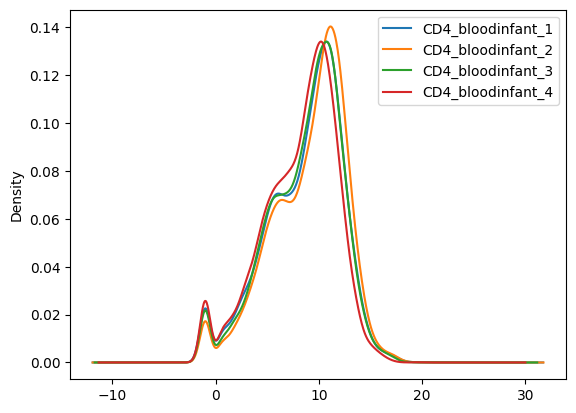

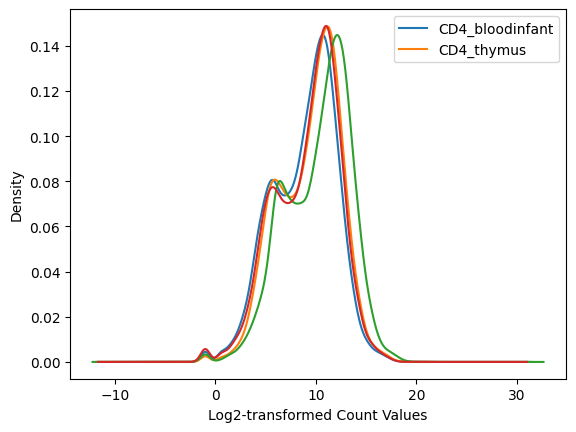

In [7]:
import numpy as np
# for rge data frame 'data_counts'
# 1. Plot the density of the log2-transformed count values for each infant CD4 T-cell sample ( where Sample ID is CD4_bloodinfant) and each thymus CD4 T-cell sample( where Sample ID is CD4_thymus).
# (Remember to add a small value, like 0.5, to all of your count values to avoid negative infinity).

import matplotlib.pyplot as plt

# Add a small value to count values to avoid negative infinity
data_counts += 0.5

# Log2-transform the count values
log2_counts = np.log2(data_counts)

# Filter the CD4_bloodinfant and CD4_thymus samples
cd4_bloodinfant_samples = log2_counts.filter(regex='CD4_bloodinfant')
cd4_thymus_samples = log2_counts.filter(regex='CD4_thymus')

# Plot the density of log2-transformed count values for each sample
cd4_bloodinfant_samples.plot.density()
cd4_thymus_samples.plot.density()

# Add labels and legend
plt.xlabel('Log2-transformed Count Values')
plt.ylabel('Density')
plt.legend(['CD4_bloodinfant', 'CD4_thymus'])

# Show the plot
plt.show()


2. Calculate the mean and the variability (which we will define for our purposes as the square root of the standard deviation). Then plot a scatter of the mean vs. variability values across genes for each source, along with the polynomial fit lines for the first 4 degrees, similar to what was done in class (you can adapt the code used in class for this). Estimating by eye looking at the polynomial fit curves, approximately at what log2 mean value does the variability start to really drop off?

**Hint** You can use `plt.xticks()` to adjust the spacing of the x axis to suit your custom needs.

In [8]:
mean_cd4_bloodinfant = np.mean(cd4_bloodinfant_samples, axis=1)
variability_cd4_bloodinfant = np.sqrt(np.std(cd4_bloodinfant_samples, axis=1))

mean_cd4_thymus = np.mean(cd4_thymus_samples, axis=1)
variability_cd4_thymus = np.sqrt(np.std(cd4_thymus_samples, axis=1))


([<matplotlib.axis.XTick at 0x140bccf8f50>,
 [Text(0, 0, '0'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(12, 0, '12'),
  Text(14, 0, '14')])

Text(0.5, 0, 'Log2 Mean')

Text(0, 0.5, 'Variability')

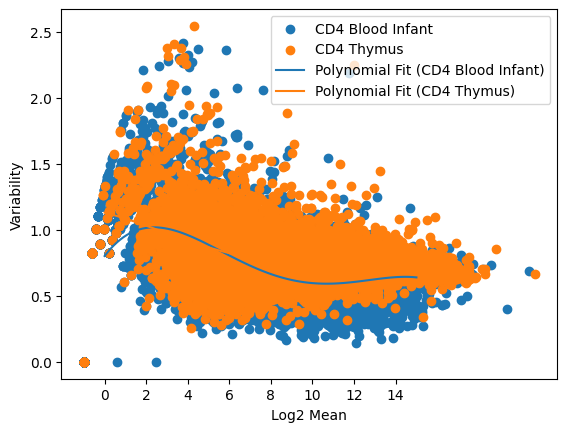

In [9]:
# Create a scatter plot of mean vs. variability for each source
plt.scatter(mean_cd4_bloodinfant, variability_cd4_bloodinfant, label='CD4 Blood Infant')
plt.scatter(mean_cd4_thymus, variability_cd4_thymus, label='CD4 Thymus')

# Fit polynomial lines for the first 4 degrees
degree = 4
coeffs_bloodinfant = np.polyfit(mean_cd4_bloodinfant, variability_cd4_bloodinfant, degree)
coeffs_thymus = np.polyfit(mean_cd4_thymus, variability_cd4_thymus, degree)

# Generate x values for the polynomial lines
x = np.linspace(0, 15, 100)

# Calculate y values for the polynomial lines
y_bloodinfant = np.polyval(coeffs_bloodinfant, x)
y_thymus = np.polyval(coeffs_thymus, x)

# Plot the polynomial lines
plt.plot(x, y_bloodinfant, label='Polynomial Fit (CD4 Blood Infant)')
plt.plot(x, y_thymus, label='Polynomial Fit (CD4 Thymus)')

# Set x-axis tick spacing
plt.xticks(np.arange(0, 16, 2))

# Add labels and legend
plt.xlabel('Log2 Mean')
plt.ylabel('Variability')
plt.legend()

# Show the plot
plt.show()


3. Filter the number of genes in the count dataset to only include overall mean above the threshold value you picked in Question 2. Plot the density of log2-transformed count values in this filtered dataset for each of CD4 T-cell samples. (Remember to add a small value, like 0.5, to all of your count values to avoid negative infinity).

Note: Notice that the trimming has shifted the density distributions near the log2 count value of 0.

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='CD4_thymus_1', ylabel='Density'>

<Axes: xlabel='CD4_thymus_1', ylabel='Density'>

<Axes: xlabel='CD4_thymus_1', ylabel='Density'>

<Axes: xlabel='CD4_thymus_1', ylabel='Density'>

<Axes: xlabel='CD4_thymus_1', ylabel='Density'>

<Axes: xlabel='CD4_thymus_1', ylabel='Density'>

<Axes: xlabel='CD4_thymus_1', ylabel='Density'>

<Axes: xlabel='CD4_thymus_1', ylabel='Density'>

Text(0.5, 0, 'Log2-transformed Count Values')

Text(0, 0.5, 'Density')

Text(0.5, 1.0, 'Density of Log2-transformed Count Values for CD4 T-cell Samples')

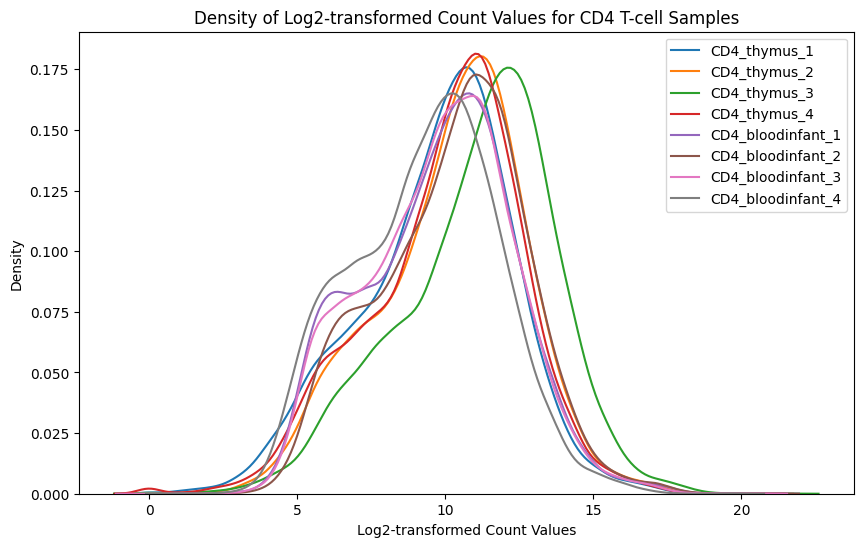

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the threshold value
threshold = 5

# Filter the genes based on the threshold value
filtered_genes = mean_cd4_bloodinfant[mean_cd4_bloodinfant > threshold].index

# Filter the count dataset based on the filtered genes
filtered_counts = data_counts.loc[filtered_genes]

# Add a small value (0.5) to avoid negative infinity
log2_counts = np.log2(filtered_counts + 0.5)

# Plot the density of log2-transformed count values for each CD4 T-cell sample
cd4_samples = [col for col in log2_counts.columns if 'CD4' in col]

plt.figure(figsize=(10, 6))
for sample in cd4_samples:
    sns.kdeplot(log2_counts[sample], label=sample)

plt.xlabel('Log2-transformed Count Values')
plt.ylabel('Density')
plt.title('Density of Log2-transformed Count Values for CD4 T-cell Samples')
plt.legend()
plt.show()


4. Let's take a look at the genes that we excluded in our trimming from Question 3. Create a data frame that only has the count values for the genes that were filtered out. Use a for-loop to calculate the Mann-Whitney U-test p-values for each gene's expression, comparing thymus expression vs. blood expression. Use the Benjamini-Hochberg FDR correction (alpha = 0.05) to adjust the p-values that you calculated. How many significant p-values did you find among expression comparisons for these excluded genes?

In [16]:
import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Step 1: Create a data frame containing count values only for the filtered-out genes
filtered_out_genes_df = filtered_genes_counts_df.loc[filtered_genes]

# Step 2: Calculate Mann-Whitney U-test p-values for each gene's expression
p_values_excluded_genes = []
for gene in filtered_out_genes_df.index:
    thymus_expression = filtered_out_genes_df.loc[gene, cd4_thymus_samples]
    blood_expression = filtered_out_genes_df.loc[gene, cd4_bloodinfant_samples]
    _, p_value = mannwhitneyu(thymus_expression, blood_expression, alternative='two-sided')
    p_values_excluded_genes.append(p_value)

# Step 3: Apply Benjamini-Hochberg FDR correction to adjust the p-values
adjusted_p_values_excluded_genes = multipletests(p_values_excluded_genes, method='fdr_bh')[1]

# Step 4: Count the number of significant p-values
significant_p_values_excluded_genes = sum(adjusted_p_values_excluded_genes < 0.05)

print("Number of significant p-values among expression comparisons for excluded genes:", significant_p_values_excluded_genes)


Number of significant p-values among expression comparisons for excluded genes: 0


The analysis indicates that there are no significant p-values among the expression comparisons for the excluded genes. This implies that none of the excluded genes showed statistically significant differences in expression between thymus and blood samples after adjusting for multiple testing

5. Read the [DESeq2 paper](https://canvas.uw.edu/courses/1632213/files/105225973?wrap=1) and attest that you have read it here for credit.

I attest that I have read the DESeq2 paper. - KEA 04/20/2024